In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")

plt.rcParams.update({
    "font.size": 18
}) 

In [7]:
def calculate_cv(theta_2, theta_3):
    sigma_h_sq = theta_3 ** 2 / (1 - theta_2 ** 2)
    return np.exp(sigma_h_sq) - 1

def plot_cv_theta_two(df_qml, df_smm, title, figsize=(7, 7), x_bounds=None, y_bounds=None):
    fig, ax = plt.subplots(figsize=figsize)
    sns.scatterplot(data=df_qml, x="cv", y="estimates_2", ax=ax, label="QML");
    sns.scatterplot(data=df_smm, x="cv", y="estimates_2", ax=ax, label="SMM");
    ax.set_xlabel("CV")
    ax.set_ylabel("theta_2")
    ax.set_title(title)
    if x_bounds is not None:
        ax.set_xlim(x_bounds)
    if y_bounds is not None:
        ax.set_ylim(y_bounds)
    return fig, ax
def plot_cv_theta_three(df_qml, df_smm, title, x_bounds=None, y_bounds=None):
    fig, ax = plt.subplots(figsize=(7, 7))
    sns.scatterplot(data=df_qml, x="cv", y="estimates_3", ax=ax, label="QML");
    sns.scatterplot(data=df_smm, x="cv", y="estimates_3", ax=ax, label="SMM");
    ax.set_xlabel("CV")
    ax.set_ylabel("theta_2")
    ax.set_title(title)
    if x_bounds is not None:
        ax.set_xlim(x_bounds)
    if y_bounds is not None:
        ax.set_ylim(y_bounds)
    return fig, ax

def plot_qml_vs_smm_estimates(df, title, figsize=(17, 7)):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=figsize)

    for i in range(1, 3):
        qml_col = f"estimates_{i+1}_qml"
        smm_col = f"estimates_{i+1}_smm"
        min_value = min(df[qml_col].min(), df[smm_col].min())
        max_vallue = max(df[qml_col].max(), df[smm_col].max())
        y_eq_x_line = np.linspace(min_value, max_vallue, 1000)
        sns.lineplot(x=y_eq_x_line, y=y_eq_x_line, ax=ax[i-1], label=r"$\hat{\theta}_{\text{QML}} = \hat{\theta}_{\text{SMM}}$", color="red", linestyle="--")
        sns.scatterplot(data=df, x=qml_col, y=smm_col, ax=ax[i-1], label=r"Пары $(\hat{\theta}_{\text{QML}}, \hat{\theta}_{\text{SMM}})$");
    fig.suptitle(title)
    plt.tight_layout()
    return fig, ax


def plot_qml_vs_smm_cv(df, title,  x_bounds=None, y_bounds=None, figsize=(7, 7)):
    fig, ax = plt.subplots(figsize=figsize)

    qml_col = "cv_qml"
    smm_col = "cv_smm"
    min_value = min(df[qml_col].min(), df[smm_col].min())
    max_vallue = max(df[qml_col].max(), df[smm_col].max())
    y_eq_x_line = np.linspace(min_value, max_vallue, 1000)
    sns.lineplot(x=y_eq_x_line, y=y_eq_x_line, ax=ax, label=r"$\hat{\text{CV}}^2_{\text{QML}} = \hat{\text{CV}}^2_{\text{SMM}}$", color="red", linestyle="--")
    sns.scatterplot(data=df, x=qml_col, y=smm_col, ax=ax, label=r"Пары $(\hat{\text{CV}}^2_{\text{QML}}, \hat{\text{CV}}^2_{\text{SMM}})$");
    ax.set_title(title)
    if x_bounds is not None:
        ax.set_xlim(x_bounds)
    if y_bounds is not None:
        ax.set_ylim(y_bounds)
    return fig, ax
    

In [3]:
def calculate_volatility_cv_sq(log_returns):
    mean_second_power = np.mean(np.power(log_returns, 2))
    mean_fourth_power = np.mean(np.power(log_returns, 4))
    return mean_fourth_power / (3 * mean_second_power**2) - 1

def plot_one_ticker(data, ticker):
    fig, ax = plt.subplots(figsize=(10, 7))
    sns.lineplot(data=data.loc[data.ticker == ticker, :], x="date", y="log_return", ax=ax)
    ax.set_title(ticker);
    return fig, ax

In [4]:
ts_data = pd.read_csv("data/Data_no_outliers.csv")
ts_data["date"] = pd.to_datetime(ts_data.date, format="%Y%m%d")

vol_cv = (
    ts_data[["ticker", "log_return"]]
    .groupby(by="ticker")
    .agg(calculate_volatility_cv_sq)
    .rename(columns={"log_return": "vol_cv_squared"})
    .reset_index()
)

qml_with_outliers = pd.read_csv("qml_estimates_with_outliers.csv")
smm_with_outliers = pd.read_csv("smm_estimates_with_outliers.csv")

qml_without_outliers = pd.read_csv("qml_estimates_without_outliers.csv")
smm_without_outliers = pd.read_csv("smm_estimates_without_outliers.csv")

data_length = pd.read_csv('data/merged_data.csv')
data_length =  data_length.groupby(by='ticker').count()['date'].tolist()


dfs = [qml_with_outliers, qml_without_outliers, smm_with_outliers, smm_without_outliers]

for idx, df in enumerate(dfs):
    df  = pd.merge(left=df, right=vol_cv, on="ticker", how="left")
    df["cv"] = calculate_cv(df.estimates_2, df.estimates_3)
    df['size'] = data_length
    df = df[df["size"] >= 1000]
    dfs[idx] = df

qml_with_outliers, qml_without_outliers = dfs[0], dfs[1]
smm_with_outliers, smm_without_outliers = dfs[2], dfs[3]

smm_with_outliers['name'] = 'smm_with_outliers'
smm_without_outliers['name'] = 'smm_without_outliers'
qml_without_outliers['name'] = 'qml_without_outliers'
qml_with_outliers['name'] = 'qml_with_outliers'


with_outliers = pd.merge(qml_with_outliers, smm_with_outliers, on="ticker", suffixes=("_qml", "_smm"))
without_outliers = pd.merge(qml_without_outliers, smm_without_outliers, on="ticker", suffixes=("_qml", "_smm"))

for df in [with_outliers, without_outliers]:
    df.rename(columns={"vol_cv_squared_smm": "cv_moments", "size_smm": "size"}, inplace=True)
    df.drop(columns=["vol_cv_squared_qml", "size_qml"], inplace=True)


### Первый вариант

In [5]:
def get_winner(theta_2, cv, size):
    is_short = size < 1000
    is_long = 1 - is_short

    is_cv_big = cv > 10
    is_cv_med = (1 - is_cv_big) * (cv > 1)
    is_cv_small = 1 - is_cv_big - is_cv_med

    is_theta_small = theta_2 < 0.9
    is_theta_med = (1 - is_theta_small) * (theta_2 < 0.95)
    is_theta_big = 1 - is_theta_small - is_theta_med

    wins_qml = np.zeros_like(size)
    wins_qml += is_long * is_cv_big
    wins_qml += is_long * is_theta_big * is_cv_med
    wins_qml += (size >= 2000) * is_theta_big * is_cv_small
    wins_qml += is_short * (size > 500) * is_theta_small * is_cv_big
    wins_qml = wins_qml > 0

    wins_smm = np.zeros_like(size)
    wins_smm += (size < 2000) * is_cv_small
    wins_smm += (size > 2000) * (size < 4000) * is_cv_small * is_theta_med
    wins_smm += is_cv_med * (1 - is_theta_big)
    wins_smm += is_short * is_theta_big * is_cv_med
    wins_smm = wins_smm > 0

    is_draw = 1 - wins_qml - wins_smm > 0

    smm_literal = pd.Series(["SMM" if flag else "" for flag in wins_smm])
    qml_literal = pd.Series(["QML" if flag else "" for flag in wins_qml])
    draw_literal = pd.Series(["?" if flag else "" for flag in is_draw])
    return smm_literal + qml_literal + draw_literal


def determine_winner(winner_qml, winner_smm):
    is_draw_qml = winner_qml == "?"
    is_draw_smm = winner_smm == "?"

    is_winner =  (winner_smm == winner_qml) * (1 - is_draw_qml) * (1 - is_draw_smm)
    return np.where(is_winner, winner_qml, pd.Series(["?" for _ in range(len(winner_qml))]))



In [5]:
for df in dfs:
    df.drop(index=np.where(df["size"] < 1000)[0], inplace=True)
    df.set_index('ticker', inplace = True)
    df["winner"] = get_winner(df["estimates_2"], df["cv"], df["size"]).to_list()



with_outliers = pd.merge(qml_with_outliers, smm_with_outliers, on="ticker", suffixes=("_qml", "_smm"))
without_outliers = pd.merge(qml_without_outliers, smm_without_outliers, on="ticker", suffixes=("_qml", "_smm"))

In [12]:
pd.Series(determine_winner(without_outliers.winner_qml, without_outliers.winner_smm)).value_counts()


SMM    21
?      20
Name: count, dtype: int64

In [13]:
without_outliers["winner"] = determine_winner(without_outliers.winner_qml, without_outliers.winner_smm)
without_outliers

,estimates_1_qml,estimates_2_qml,estimates_3_qml,cv_qml,size_qml,name_qml,winner_qml,estimates_1_smm,estimates_2_smm,estimates_3_smm,cv_smm,size_smm,name_smm,winner_smm,winner
ticker,,,,,,,,,,,,,,,
AFKS,-0.848200,0.897031,0.388591,1.166354,2323,qml_without_outliers,SMM,-0.813689,0.901284,0.470587,2.254055,2323,smm_without_outliers,SMM,SMM
AFLT,-0.677685,0.918708,0.407844,1.904984,2323,qml_without_outliers,SMM,-0.807593,0.903855,0.509211,3.122934,2323,smm_without_outliers,SMM,SMM
AGRO,-0.577343,0.932188,0.431502,3.141461,2298,qml_without_outliers,SMM,-0.916565,0.892177,0.544191,3.269719,2298,smm_without_outliers,SMM,SMM
ALRS,-0.346496,0.958155,0.213216,0.741615,2323,qml_without_outliers,QML,-0.812531,0.901828,0.416201,1.528908,2323,smm_without_outliers,SMM,?
BSPB,-0.655392,0.924218,0.416618,2.288093,2321,qml_without_outliers,SMM,-1.172861,0.864563,0.642326,4.123254,2321,smm_without_outliers,SMM,SMM
CBOM,-0.173194,0.982202,0.204142,2.258565,2203,qml_without_outliers,QML,-0.759176,0.921572,0.455197,2.954672,2203,smm_without_outliers,SMM,?
CHMF,-0.239182,0.971257,0.137365,0.395178,2323,qml_without_outliers,QML,-0.939088,0.889566,0.480987,2.030319,2323,smm_without_outliers,SMM,?
ENPG,-1.118254,0.859984,0.543504,2.108926,1031,qml_without_outliers,SMM,-0.965947,0.879787,0.576755,3.358148,1031,smm_without_outliers,SMM,SMM
FEES,-0.370991,0.955771,0.330027,2.522398,2309,qml_without_outliers,QML,-0.522026,0.938173,0.446529,4.279961,2309,smm_without_outliers,SMM,?


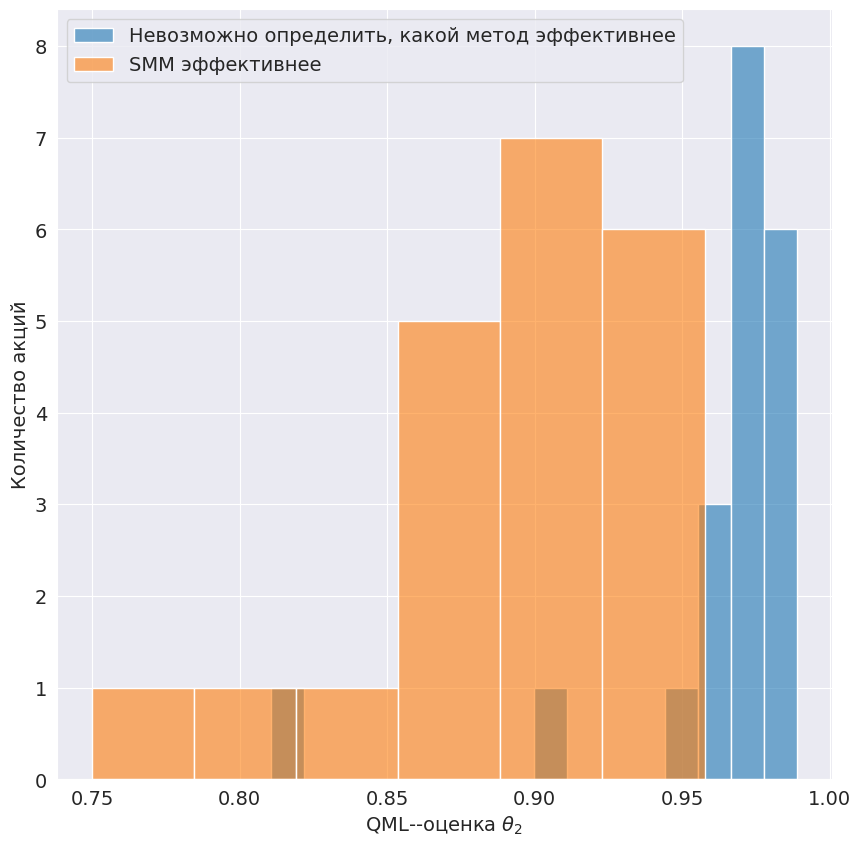

In [14]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.histplot(data=with_outliers[without_outliers.winner == "?"], x="estimates_2_qml", stat="count", label="Невозможно определить, какой метод эффективнее", alpha=0.6)
sns.histplot(data=with_outliers[without_outliers.winner == "SMM"], x="estimates_2_qml", stat="count", label="SMM эффективнее", alpha=0.6)

ax.set_xlabel(r'QML--оценка $\theta_2$')
ax.set_ylabel(r'Количество акций')

ax.legend()
plt.savefig("data/plots/theta_two_estimates.pdf", format="pdf");

### Второй вариант

Оценивали - Руиз (1994), M. Hakan Eratalay, Harvey et al (1994), Harvey Sheppard (1996), Brorto Ruiz 1994, Bos Charles 2015, Md. Nazmul Ahsana and Jean-Marie Dufourb 2019, Jacquier et al. 1994 (MCMC), Sandman (недельные данные) - баесовщица, 
План
1) Мы взяли такие то данные, почистили их и оценили модель... (берем только $T >= 1000$)
2) Построить гистрограммы оценок - заметим разные формы распределения и  дисперсию
3) Посмотреть как связаны параметры друг с другом (один занижает, другой завышает. Можно сослаться на руиза)
4) Поговорить про корреляцию, что они связаны через матож
5) Поговорить про одномерное распределение CV^2. Сделать вывод, что у одного выше cv в среднем и ссылка на литру. (Руиз 1994, Harvey Sheppard (1996)), Brorto Ruiz 1994
6) График CV^2 и тета, в какой области мы находимся
7) Исследование выбросов*

#### Пункт 2

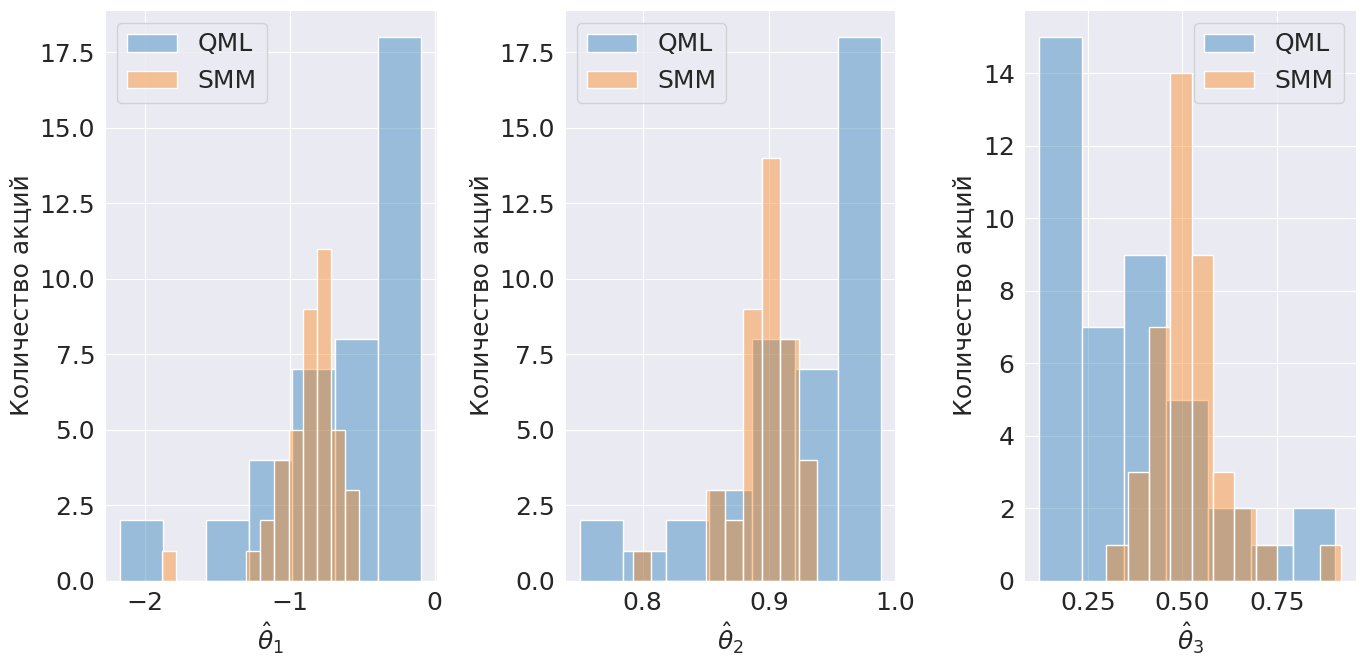

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(14, 7))
stat = "estimates"
name_to_label = {"qml": "QML", "smm": "SMM"}
# name_to_bins = {"qml": 9, "smm": 9}
for param_idx in range(1, 4):
    for name in ["qml", "smm"]:
        sns.histplot(data=without_outliers, x=f"{stat}_{param_idx}_{name}", label=name_to_label[name], ax=ax[param_idx - 1], alpha=0.4, kde=False, stat="count")

for axis, label in zip(ax, [r"$\hat{\theta}_1$", r"$\hat{\theta}_2$", r"$\hat{\theta}_3$"]):
    axis.set_ylabel("Количество акций")
    axis.set_xlabel(label)
    axis.legend()

plt.tight_layout();
plt.savefig("data/plots/estimates_histograms.pdf", format="pdf")

#### Пункт 3

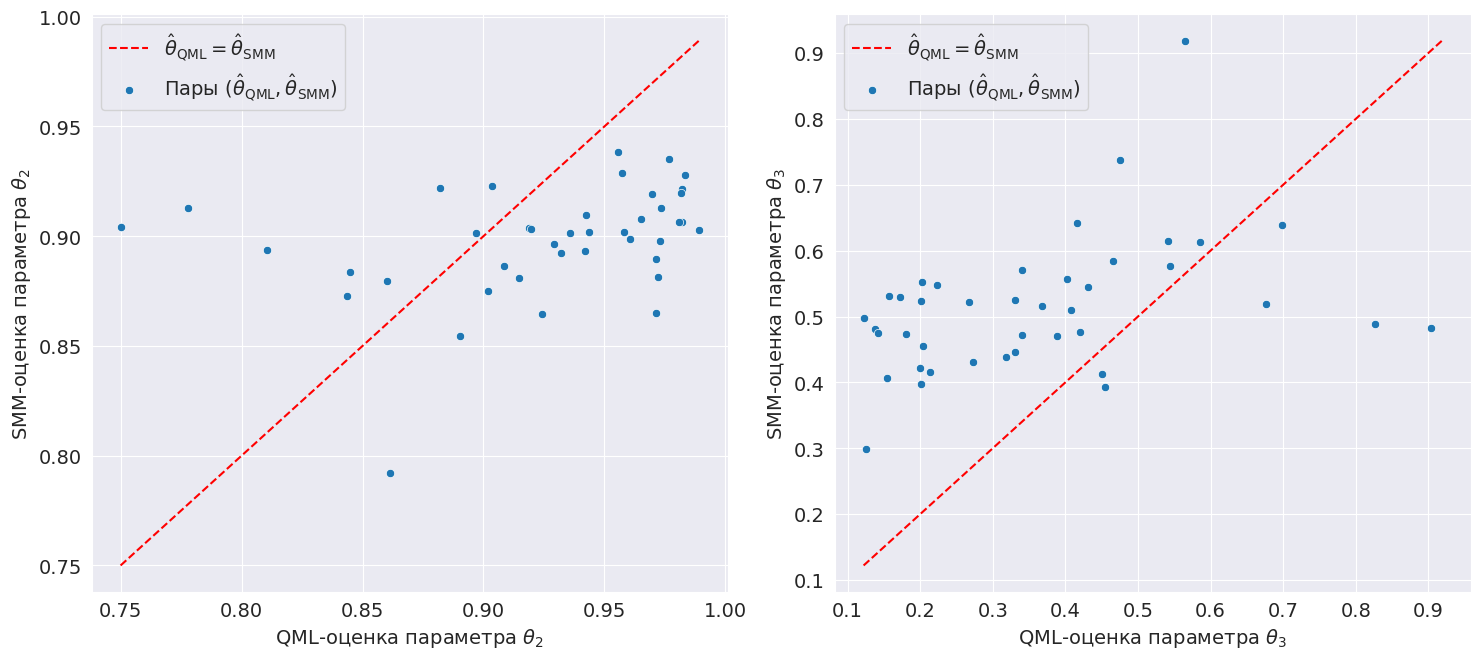

In [272]:
fig, axes = plot_qml_vs_smm_estimates(without_outliers, "", figsize=(15, 7))

for idx, ax in enumerate(axes, 2):
    ax.set_xlabel(f"QML-оценка параметра " + r"$\theta" + f"_{idx}" + r"$")
    ax.set_ylabel(f"SMM-оценка параметра " + r"$\theta" + f"_{idx}" + r"$")

plt.savefig("data/plots/estimates_pairs.pdf", format="pdf")

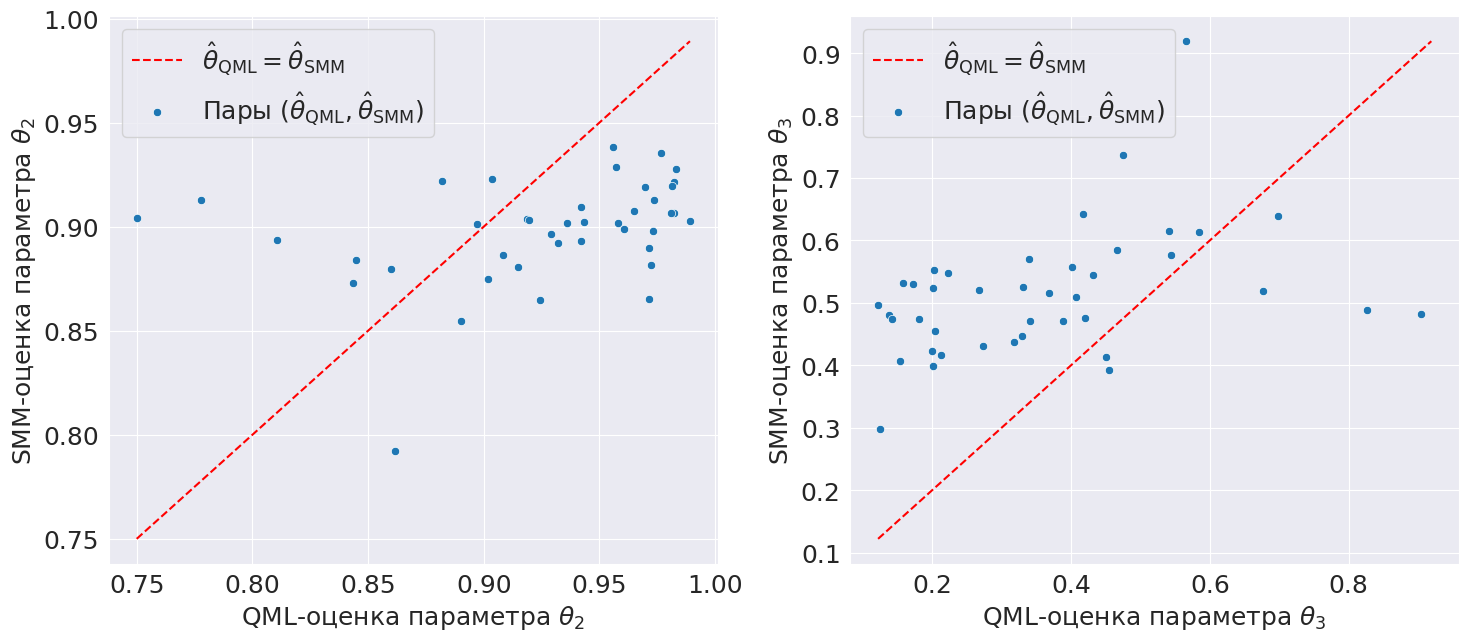

In [5]:
fig, axes = plot_qml_vs_smm_estimates(without_outliers, "", figsize=(15, 7))

for idx, ax in enumerate(axes, 2):
    ax.set_xlabel(f"QML-оценка параметра " + r"$\theta" + f"_{idx}" + r"$")
    ax.set_ylabel(f"SMM-оценка параметра " + r"$\theta" + f"_{idx}" + r"$")

plt.savefig("data/plots/estimates_pairs.pdf", format="pdf")

#### Пункт 4

In [299]:
without_outliers[[f"estimates_{i}_qml" for i in range(1, 4)]].corr()

,estimates_1_qml,estimates_2_qml,estimates_3_qml
estimates_1_qml,1.000000,0.997391,-0.930402
estimates_2_qml,0.997391,1.000000,-0.924910
estimates_3_qml,-0.930402,-0.924910,1.000000


In [300]:
without_outliers[[f"estimates_{i}_smm" for i in range(1, 4)]].corr()

,estimates_1_smm,estimates_2_smm,estimates_3_smm
estimates_1_smm,1.000000,0.986320,-0.805203
estimates_2_smm,0.986320,1.000000,-0.799076
estimates_3_smm,-0.805203,-0.799076,1.000000


#### Пункт 5

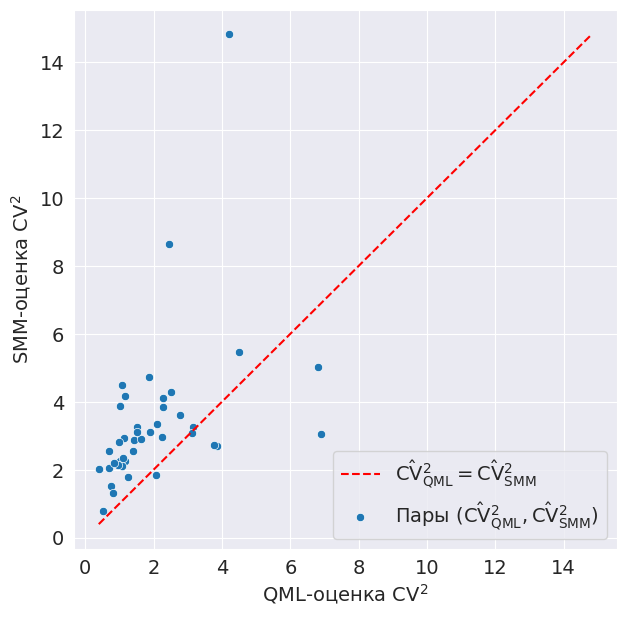

In [286]:
fig, ax = plot_qml_vs_smm_cv(without_outliers, "")

ax.set_xlabel(r"QML-оценка $\text{CV}^2$")
ax.set_ylabel(r"SMM-оценка $\text{CV}^2$")
plt.savefig("data/plots/cv_pairs.pdf", format="pdf");

#### Пункт 6

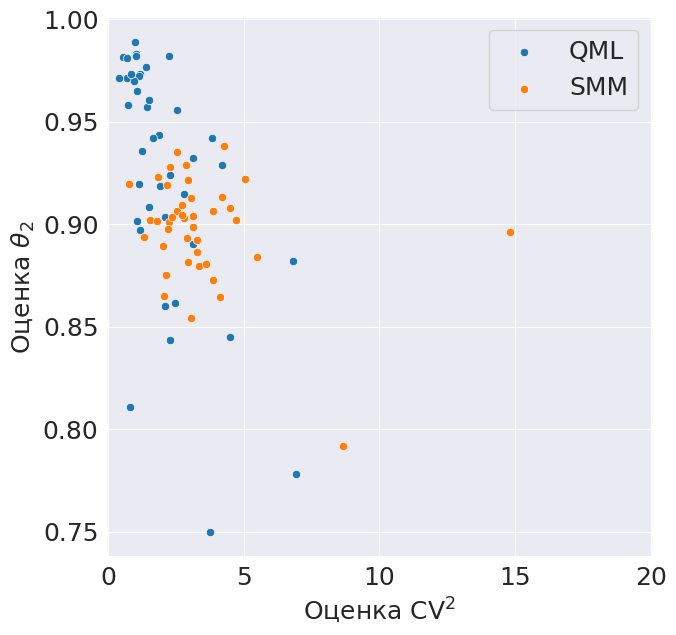

In [11]:
fig, ax = plot_cv_theta_two(qml_without_outliers, smm_without_outliers, "", figsize=(7, 7), x_bounds=(0, 20))
ax.set_xlabel(r"Оценка $\text{CV}^2$")
ax.set_ylabel(r"Оценка $\theta_2$")
plt.savefig("data/plots/cv_theta2_scatter.pdf", format="pdf");

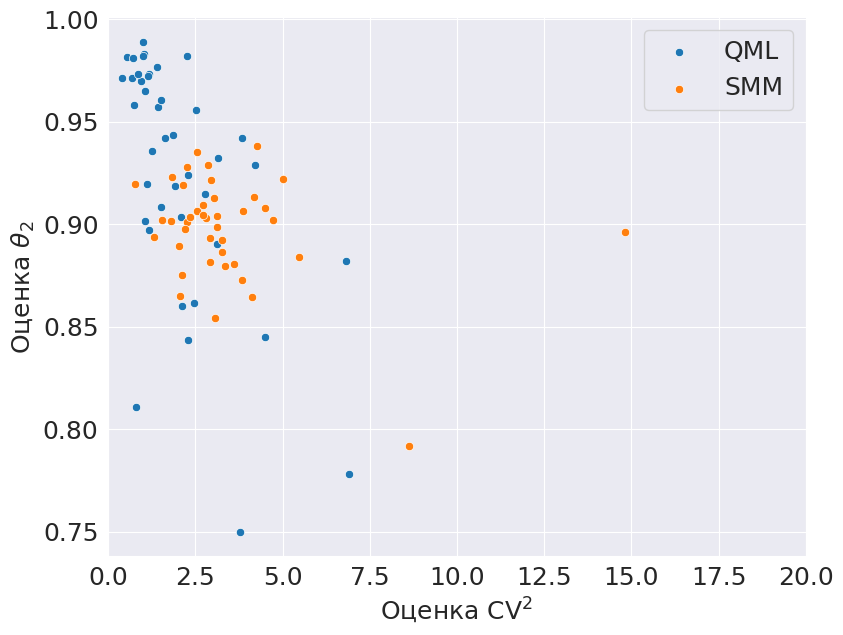

In [14]:
fig, ax = plot_cv_theta_two(qml_without_outliers, smm_without_outliers, "", figsize=(9, 7), x_bounds=(0, 20))
ax.set_xlabel(r"Оценка $\text{CV}^2$")
ax.set_ylabel(r"Оценка $\theta_2$")
plt.savefig("data/plots/cv_theta2_scatter.pdf", format="pdf");

#### Остальное

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


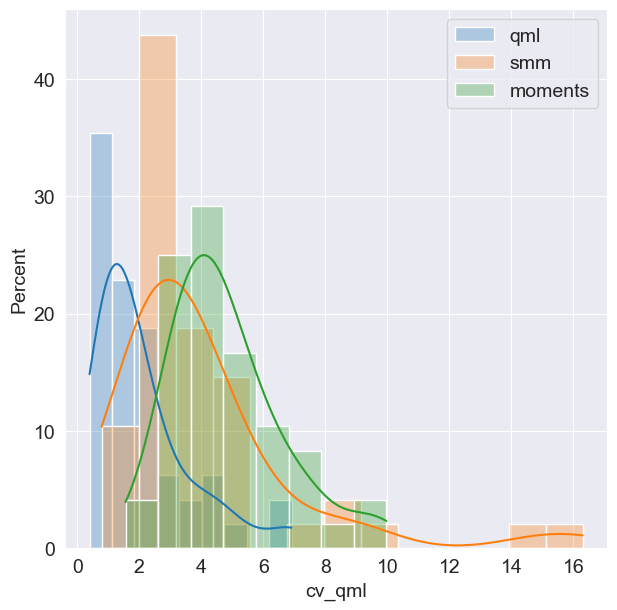

In [14]:
fig, ax = plt.subplots(figsize=(7, 7))
for name in ["qml", "smm", "moments"]:
    sns.histplot(data=without_outliers, x=f"cv_{name}", label=name, ax=ax, alpha=0.3, kde=True, stat="percent")
# ax.set_xlabel(r"$\text{CV}^2$")
ax.legend();

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


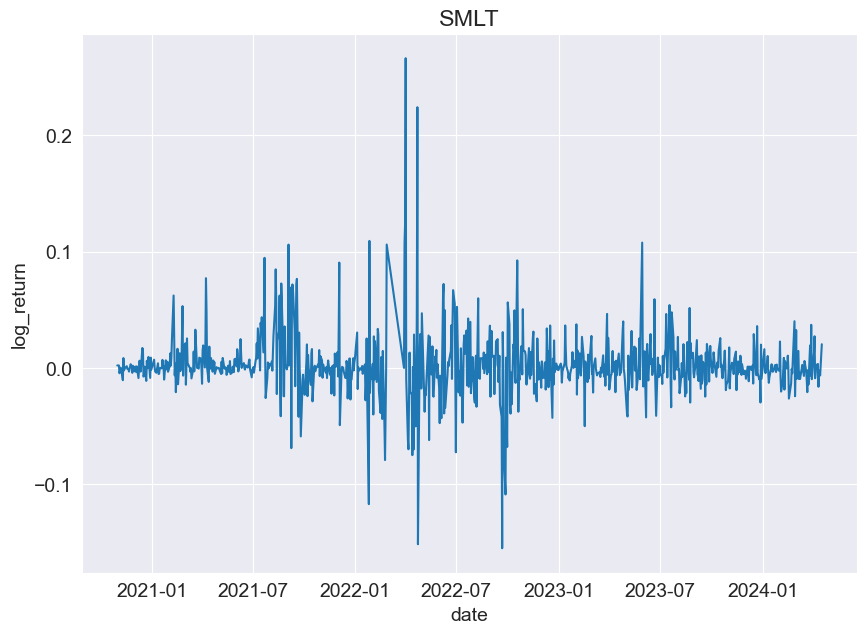

In [32]:
plot_one_ticker(ts_data, "SMLT")

### Табличка с оценками

In [12]:
from itertools import product
columns = ["ticker"] + [f"estimates_{idx}_{method}" for idx, method in product(range(1, 4), ("qml", "smm"))]
with open("result_table.txt", "w") as f:
    without_outliers.to_latex(
        buf=f,
        columns=columns,
        column_format="lcccccc",
        index=False,
        index_names=False,
        float_format="%.3f",
        longtable=True
    )